In [1]:
import pandas as pd
import numpy as np
from IPython.display import Image

from gastrodon import RemoteEndpoint,QName,ttl,URIRef,inline
import requests
import json
import time

The gastrodon library is imported to use SPARQL in Jupyter notebooks.

## Extracting a disease/symptom dataset from DBpedia

Defining the prefix for the namespace: the DBpedia ontology.

In [2]:
prefixes=inline("""
    @prefix dbo: <http://dbpedia.org/ontology/> .
""").graph

Setting up a SPARQL endpoint that connects to the DBpedia knowledge graph.

In [3]:
endpoint=RemoteEndpoint(
    "http://dbpedia.org/sparql/"
    ,default_graph="http://dbpedia.org"
    ,prefixes=prefixes
    ,base_uri="http://dbpedia.org/resource/"
)

Writing a query to select:
* all DBpedia entities that have the class 'disease' (https://dbpedia.org/ontology/Disease)  
* which also have the property 'meshId' (https://dbpedia.org/ontology/meshId)
* and list each disease's symptoms (https://dbpedia.org/ontology/symptom) 
* and each symptom's meshId.

In [4]:
db_data = endpoint.select("""
    SELECT ?disease ?disease_mesh ?symptom ?symptom_mesh WHERE {
    ?disease a dbo:Disease .
    ?disease dbo:meshId ?disease_mesh .
    ?disease dbo:symptom ?symptom .
    ?symptom dbo:meshId ?symptom_mesh .
}
ORDER BY ?disease
""")

## Investigating the dataset

In [5]:
db_data

,disease,disease_mesh,symptom,symptom_mesh
0,<Abscess>,D000038,<Erythema>,D004890
1,<Achondroplasia>,D000130,<Macrocephaly>,D058627
2,<Acne>,D000152,<Scar>,D002921
3,<Acrocallosal_syndrome>,D055673,<Psychomotor_retardation>,D011596
4,<Acrocallosal_syndrome>,D055673,<Polydactyly>,D017689
...,...,...,...,...
1199,<Yellow_fever>,D015004,<Jaundice>,D007565
1200,<Yellow_fever>,D015004,<Chills>,D023341
1201,<Yellow_fever>,D015004,<Myalgia>,D063806
1202,<Yellow_fever>,D015004,<Headache>,D006261


In [6]:
db_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1204 entries, 0 to 1203
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   disease       1204 non-null   object
 1   disease_mesh  1204 non-null   object
 2   symptom       1204 non-null   object
 3   symptom_mesh  1204 non-null   object
dtypes: object(4)
memory usage: 37.8+ KB


There are no missing values in the dataset:

In [7]:
db_data.isna().sum()

disease         0
disease_mesh    0
symptom         0
symptom_mesh    0
dtype: int64

In [8]:
db_data.nunique()

disease         473
disease_mesh    465
symptom         245
symptom_mesh    238
dtype: int64

The number of unique diseases should be the same as the number of unique meshIds. Therefore the dataset requires some fixing.

## Fixing the incorrect MeSH codes in the dataset

### Fixing disease MeSH codes

Valid MeSH codes should be 7 characters long. Investigating unusual MeSH codes in the diseases:

In [9]:
[id for id in pd.Series(db_data["disease_mesh"].unique()) if len(id) != 7 ]

['', 'D00248', 'C538604 D050336', 'C14.907.690']

Investigating the first of the 4 issues: the "missing" MeSH codes. Which diseases have codes that are empty strings?

In [10]:
db_data[db_data["disease_mesh"]==""].head()

,disease,disease_mesh,symptom,symptom_mesh
71,<Alzheimer's_disease>,,<Amnesia>,D000647
73,<Alzheimer's_disease>,,<Primary_progressive_aphasia>,D018888
192,<Bronchitis>,,<Cough>,D003371
194,<Bronchitis>,,<Shortness_of_breath>,D004417
382,<Eclampsia>,,<Seizure>,D012640


In [11]:
db_data[db_data["disease"]=="<Alzheimer's_disease>"]

,disease,disease_mesh,symptom,symptom_mesh
71,<Alzheimer's_disease>,,<Amnesia>,D000647
72,<Alzheimer's_disease>,D000544,<Amnesia>,D000647
73,<Alzheimer's_disease>,,<Primary_progressive_aphasia>,D018888
74,<Alzheimer's_disease>,D000544,<Primary_progressive_aphasia>,D018888


It seems like the "empty" codes are a result of the some of the disease entities having any "empty" object for the dbo:meshId property. 

In [12]:
# an example of the disease "Alzheimer's" having one empty MeSH code in DBpedia.
endpoint.select("""
    SELECT ?disease ?mesh WHERE {
    ?disease dbo:wikiPageID 18914017 .
    ?disease dbo:meshId ?mesh .
}
ORDER BY ?disease
""")

,disease,mesh
0,<Alzheimer's_disease>,
1,<Alzheimer's_disease>,D000544


These rows can therefore simply be dropped in the dataset.

In [13]:
db_data["disease_mesh"] = db_data["disease_mesh"].replace("", np.nan)
db_data = db_data.dropna(axis=0, how="any").reset_index(drop=True)

Looking at one the disease MeSH that is too short:

In [14]:
db_data[db_data["disease_mesh"]=="D00248"]

,disease,disease_mesh,symptom,symptom_mesh
232,<Cellulitis>,D00248,<Fever>,D005334


With reference to the National Library of Medicine's descriptor for the disease "Cellulitis": https://meshb.nlm.nih.gov/record/ui?ui=D002481,  
it seems as if the DBPedia entry was mistyped, with one digit missing from the end of the MeSH code. The correct code "D002481" is manually adjusted in the dataset.

In [15]:
db_data.at[232, 'disease_mesh'] = "D002481"

Looking at the disease MeSH that has been "doubled":

In [16]:
db_data[db_data["disease_mesh"]=="C538604 D050336"]

,disease,disease_mesh,symptom,symptom_mesh
766,<Mulibrey_nanism>,C538604 D050336,<Infertility>,D007246


Once again referencing the National Library of Medicine, the correct MeSH for "Mulibrey Nanism" is "D050336".

In [17]:
db_data.at[766, "disease_mesh"] = "D050336"

Looking at the MeSH code C14.907.690:

In [18]:
db_data[db_data["disease_mesh"]=="C14.907.690"]

,disease,disease_mesh,symptom,symptom_mesh
931,<Pulmonary_venoocclusive_disease>,C14.907.690,<Fatigue>,D005221


The correct code for this disease is: "D011668". The "Tree Number" for this disease was incorrectly entered into the DBpedia knowledge graph.

In [19]:
db_data.at[931, "disease_mesh"] = "D011668"

The diseases and their MeSH codes still don't align properly.

In [20]:
db_data.nunique()

disease         473
disease_mesh    464
symptom         245
symptom_mesh    238
dtype: int64

There are more unique diseases than MeSH codes, suggesting that different diseases have been assigned to the same MeSH code.

In [21]:
group_dis_mesh = db_data.groupby("disease_mesh")["disease"].nunique()
db_data[db_data["disease_mesh"].isin(list(group_dis_mesh[group_dis_mesh > 1].reset_index()["disease_mesh"]))].sort_values("disease_mesh").groupby("disease_mesh")["disease"].value_counts()

disease_mesh  disease                                  
D001342       <Dysautonomia>                               1
              <Pure_autonomic_failure>                     1
D001991       <Acute_bronchitis>                           3
              <Bronchitis>                                 2
D005334       <Fever>                                      3
              <Hyperthermia>                               1
D006471       <Gastrointestinal_bleeding>                  2
              <Upper_gastrointestinal_bleeding>            1
D007003       <Hypoglycemia>                               6
              <Reactive_hypoglycemia>                      1
D013617       <Paroxysmal_supraventricular_tachycardia>    2
              <Supraventricular_tachycardia>               2
D014717       <Benign_paroxysmal_positional_vertigo>       1
              <Vertigo>                                    1
D015423       <Episcleritis>                               1
              <Scleritis>    

There are some diseases that DBpedia has separated into two diseases, such as "Acute Bronchitis" and "Bronchitis" that in the medical codes however are simply described as one concept.  
Others, such as "Hyperthermia" have simply been mislabelled with the wrong MeSH code.

These must be fixed manually, with reference to the National Library of Medicine guide. Relabelling the diseases that are the same, but have been given different names:

In [22]:
db_data["disease"].replace("<Pure_autonomic_failure>", "<Dysautonomia>", inplace=True)
db_data["disease"].replace("<Acute_bronchitis>", "<Bronchitis>", inplace=True)
db_data["disease"].replace("<Upper_gastrointestinal_bleeding>", "<Gastrointestinal_bleeding>", inplace=True)
db_data["disease"].replace("<Reactive_hypoglycemia>", "<Hypoglycemia>", inplace=True)
db_data["disease"].replace("<Paroxysmal_supraventricular_tachycardia>", "<Supraventricular_tachycardia>", inplace=True)
db_data["disease"].replace("<Benign_paroxysmal_positional_vertigo>", "<Vertigo>", inplace=True)
db_data["disease"].replace("<Episcleritis>", "<Scleritis>", inplace=True)
db_data["disease"].replace("<Panic_attack>", "<Panic_disorder>", inplace=True)

Fixing the code for Hyperthermia:

In [23]:
db_data.at[db_data[db_data["disease"]=="<Hyperthermia>"].index[0], "disease_mesh"] = "D000084462"

Dropping any duplicate rows created in the relabelling of some of the diseases:

In [24]:
db_data = db_data.drop_duplicates().reset_index(drop=True)

In [25]:
db_data

,disease,disease_mesh,symptom,symptom_mesh
0,<Abscess>,D000038,<Erythema>,D004890
1,<Achondroplasia>,D000130,<Macrocephaly>,D058627
2,<Acne>,D000152,<Scar>,D002921
3,<Acrocallosal_syndrome>,D055673,<Psychomotor_retardation>,D011596
4,<Acrocallosal_syndrome>,D055673,<Polydactyly>,D017689
...,...,...,...,...
1159,<Yellow_fever>,D015004,<Jaundice>,D007565
1160,<Yellow_fever>,D015004,<Chills>,D023341
1161,<Yellow_fever>,D015004,<Myalgia>,D063806
1162,<Yellow_fever>,D015004,<Headache>,D006261


### Fixing symptom MeSH codes

With the disease MeSH codes fixed, now investigating unusual MeSH codes in the symptoms:

In [26]:
[id for id in pd.Series(db_data["symptom_mesh"].unique()) if len(id) != 7]

['']

In [27]:
db_data[db_data["symptom_mesh"]==""]

,disease,disease_mesh,symptom,symptom_mesh
365,<Dyslipidemia>,D050171,<Atherosclerosis>,
652,<Lemierre's_syndrome>,D057831,<Sepsis>,


For the symptoms it seems there are only immediately two problematic MeSH codes: where they are missing for "sepsis" and "Atherosclerosis". These can be manually fixed.

In [28]:
# adding the code for Atherosclerosis
db_data.at[365, "symptom_mesh"] = "D050197"
# adding the code for Sepsis
db_data.at[652, "symptom_mesh"] = "D018805"

In [29]:
db_data.nunique()

disease         465
disease_mesh    465
symptom         245
symptom_mesh    237
dtype: int64

There are more symptoms than symptom mesh codes, suggesting that some of the same mesh codes have assigned to different symptoms.

In [30]:
group_s_mesh = db_data.groupby("symptom_mesh")["symptom"].nunique()
db_data[db_data["symptom_mesh"].isin(list(group_s_mesh[group_s_mesh > 1].reset_index()["symptom_mesh"]))].sort_values("symptom_mesh").groupby("symptom_mesh")["symptom"].value_counts()

symptom_mesh  symptom                    
D005334       <Fever>                        94
              <Hyperthermia>                  1
D006471       <Hematochezia>                  3
              <Gastrointestinal_bleeding>     2
D010612       <Sore_throat>                   7
              <Pharyngitis>                   2
D011693       <Petechia>                      3
              <Purpura>                       2
D012798       <Drooling>                      1
              <Hypersalivation>               1
D013575       <Syncope_(medicine)>           12
              <Lightheadedness>              10
D014202       <Tremor>                        3
              <Intention_tremor>              1
D018908       <Muscle_weakness>               9
              <Weakness>                      8
Name: symptom, dtype: int64

 Relabelling the symptoms that are the same, but have been given different names:

In [31]:
db_data["symptom"].replace("<Hematochezia>", "<Gastrointestinal_bleeding>", inplace=True)
db_data["symptom"].replace("<Sore_throat>", "<Pharyngitis>", inplace=True)
db_data["symptom"].replace("<Petechia>", "<Purpura>", inplace=True)
db_data["symptom"].replace("<Hypersalivation>", "<Drooling>", inplace=True)
db_data["symptom"].replace("<Syncope_(medicine)>", "<Lightheadedness>", inplace=True)
db_data["symptom"].replace("<Intention_tremor>", "<Tremor>", inplace=True)
db_data["symptom"].replace("<Weakness>", "<Muscle_weakness>", inplace=True)

Fixing the code for Hyperthermia:

In [32]:
db_data.at[db_data[db_data["symptom"]=="<Hyperthermia>"].index[0], "symptom_mesh"] = "D000084462"

Dropping any duplicate rows:

In [33]:
db_data = db_data.drop_duplicates().reset_index(drop=True)

The MeSH codes in the dataset for each of the diseases and symptoms columns have now been fixed.

In [34]:
db_data.nunique()

disease         465
disease_mesh    465
symptom         238
symptom_mesh    238
dtype: int64

### Standardising disease and symptom MeSH codes

Sometimes a disease can also be a symptom. In the DBPedia dataset are 55 conditions which are classified as both diseases, and symptoms of other diseases.

In [35]:
len(set(db_data["disease"]).intersection(set(db_data["symptom"])))

56

Sometimes the same condition has been described with a different label between the symptoms and diseases columns. This must be standardised.

In [36]:
temp_join = db_data.copy()[["disease", "disease_mesh"]]
temp_join.columns = ["dis/symp", "mesh"]
temp_join = pd.concat([temp_join, db_data[["symptom", "symptom_mesh"]].rename(columns={"symptom":"dis/symp", "symptom_mesh":"mesh"})])

Again referencing the National Library of Medicine to manually select the best descriptor.

In [37]:
group_both_mesh = temp_join.groupby("mesh")["dis/symp"].nunique()
temp_join[temp_join["mesh"].isin(list(group_both_mesh[group_both_mesh > 1].reset_index()["mesh"]))].sort_values("mesh").groupby("mesh")["dis/symp"].value_counts()

mesh     dis/symp               
D001714  <Mania>                     2
         <Bipolar_disorder>          1
D009369  <Cancer>                    1
         <Neoplasm>                  1
D011595  <Psychomotor_agitation>     3
         <Akathisia>                 1
D012640  <Seizure>                  19
         <Convulsion>                1
D016584  <Panic_disorder>            2
         <Panic_attack>              1
Name: dis/symp, dtype: int64

In [38]:
db_data["symptom"].replace("<Mania>", "<Bipolar_disorder>", inplace=True)
db_data["symptom"].replace("<Cancer>", "<Neoplasm>", inplace=True)
db_data["symptom"].replace("<Panic_attack>", "<Panic_disorder>", inplace=True)
db_data["disease"].replace("<Convulsion>", "<Seizure>", inplace=True)
db_data = db_data.drop(db_data[db_data["disease"]=="<Akathisia>"].index[0], axis=0).reset_index(drop=True)

## Cleaning the disease and symptom names in the dataset

In [39]:
db_data["disease"] = db_data["disease"].str.strip("<>").str.replace("_", " ")
db_data["symptom"] = db_data["symptom"].str.strip("<>").str.replace("_", " ")

The final DBpedia dataset:

In [40]:
db_data.head()

,disease,disease_mesh,symptom,symptom_mesh
0,Abscess,D000038,Erythema,D004890
1,Achondroplasia,D000130,Macrocephaly,D058627
2,Acne,D000152,Scar,D002921
3,Acrocallosal syndrome,D055673,Psychomotor retardation,D011596
4,Acrocallosal syndrome,D055673,Polydactyly,D017689


## Mapping the MeSH codes to UMLS Codes

UMLS codes (Unified Medical Language System) are a standardised way of representing the diseases. Therefore the different codes used by different datasets will all be standardised to UMLS. The UMLS Metathesaurus API will be needed to map the MeSH code to UMLS codes.

Finding every unique MeSH code in the DBpedia dataset:

In [41]:
all_mesh = list(pd.concat([db_data["disease_mesh"], db_data["symptom_mesh"]]).unique())

Define the UMLS API URI:

In [42]:
api = "https://uts-ws.nlm.nih.gov/rest/search/current"
apiKey = json.load(open("../umls_api_key.json"))["apiKey"]

Finding the respective UMLS code for every MeSH code in the DBpedia dataset:

Manually fixing the one disease with an incorrect MeSH code, that could not be mapped to UMLS.

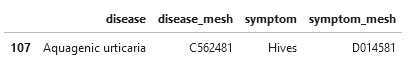

In [43]:
Image("https://i.imgur.com/wJpSE5T.png")

In [44]:
db_data.at[107, "disease_mesh"] = "D000094482"

Saving the results so they can be reused:

In [45]:
mesh_to_umls_df = pd.read_csv("code_maps/mesh_to_umls_db_dict.csv")
mesh_to_umls = mesh_to_umls_df.set_index("MeSH Code")["UMLS Code"].to_dict()

In [46]:
mesh_to_umls_df.head()

,MeSH Code,UMLS Code
0,D000038,C0000833
1,D000130,C0001080
2,D000152,C0001144
3,D055673,C0796147
4,D001991,C0006277


Using the generated dictionary to map the MeSH codes to UMLS codes:

In [47]:
db_data["disease_umls"] = db_data["disease_mesh"].map(mesh_to_umls)
db_data["symptom_umls"] = db_data["symptom_mesh"].map(mesh_to_umls)

In [48]:
db_data

,disease,disease_mesh,symptom,symptom_mesh,disease_umls,symptom_umls
0,Abscess,D000038,Erythema,D004890,C0000833,C0041834
1,Achondroplasia,D000130,Macrocephaly,D058627,C0001080,C0221355
2,Acne,D000152,Scar,D002921,C0001144,C2004491
3,Acrocallosal syndrome,D055673,Psychomotor retardation,D011596,C0796147,C5441816
4,Acrocallosal syndrome,D055673,Polydactyly,D017689,C0796147,C0152427
...,...,...,...,...,...,...
1154,Yellow fever,D015004,Jaundice,D007565,C0043395,C0242183
1155,Yellow fever,D015004,Chills,D023341,C0043395,C0085593
1156,Yellow fever,D015004,Myalgia,D063806,C0043395,C0231528
1157,Yellow fever,D015004,Headache,D006261,C0043395,C0877781


## Reshaping the dataset to be suitable for import to Gephi

The data must be reshaped into two different tables: one containing all of the nodes and their labels, and another describing the edges between the given nodes.

### Creating a "nodes" table

Creating a dataframe that contains only each "node", i.e. each disease or symptom, and its associated UMLS code. Starting by including all of the diseases:

In [49]:
nodes_table = db_data.copy()[["disease_umls", "disease"]]
nodes_table.columns = ["Id", "Label"]

Then adding all of the symptoms to the table:

In [50]:
nodes_table = pd.concat([nodes_table, db_data[["symptom_umls", "symptom"]].rename(columns={"symptom_umls":"Id", "symptom":"Label"})])

Removing all of the duplicate diseases/symptoms:

In [51]:
nodes_table = nodes_table.drop_duplicates()

Checking that the UMLS codes are all correct:

In [52]:
nodes_table.nunique()

Id       642
Label    642
dtype: int64

Adding an optional column, indicating whether a condition is either a disease or symptom. The classification is not clear cut, because some conditions can exist as either a disease or a symptom. "Symptom" is chosen to take priority, due to the fewer number of symptoms in the dataset.

In [53]:
print("Number of symptoms:", db_data["symptom"].nunique(), 
"\nNumber of diseases:", db_data["disease"].nunique(), 
"\nNumber of conditions existing as both a symptom and disease:", len(set(db_data["symptom"]).intersection(set(db_data["disease"]))))

Number of symptoms: 238 
Number of diseases: 464 
Number of conditions existing as both a symptom and disease: 60


In [54]:
nodes_table["condition"] = nodes_table["Id"].isin(db_data["symptom_umls"].unique()).replace({True: "symptom", False: "disease"})

In [55]:
nodes_table

,Id,Label,condition
0,C0000833,Abscess,symptom
1,C0001080,Achondroplasia,disease
2,C0001144,Acne,symptom
3,C0796147,Acrocallosal syndrome,disease
5,C0006277,Bronchitis,disease
...,...,...,...
1103,C0020505,Polyphagia,symptom
1130,C0234482,Aphasia,symptom
1149,C0013374,Dysgammaglobulinemia,symptom
1152,C0025209,Freckle,symptom


There are 642 unique diseases/symptoms in the DBpedia dataset.

In [56]:
nodes_table.shape

(642, 3)

### Creating an "edges" table

In [57]:
edges_table = db_data.copy()[["disease", "symptom", "disease_umls", "symptom_umls"]]

Creating columns for:  
* the source and target of the edge (the two nodes)
* the label for the edge 
* the unique id for the edge
* the type of edge (directed)
* the weight of the edge - as DBpedia does not suggest that any one symptom is more important than the others, all edges are given equal weights.

In [58]:
edges_table.columns = ["disease", "symptom", "Source", "Target"]
edges_table["Label"] = "Edge from " + edges_table["disease"] + " to " + edges_table["symptom"]
edges_table["Id"] = edges_table["Source"] + "_" + edges_table["Target"]
edges_table["Type"] = "Directed"
edges_table["Weight"] = 1

In [59]:
edges_table = edges_table[["Source", "Target", "Type", "Id", "Label", "Weight"]]
edges_table

,Source,Target,Type,Id,Label,Weight
0,C0000833,C0041834,Directed,C0000833_C0041834,Edge from Abscess to Erythema,1
1,C0001080,C0221355,Directed,C0001080_C0221355,Edge from Achondroplasia to Macrocephaly,1
2,C0001144,C2004491,Directed,C0001144_C2004491,Edge from Acne to Scar,1
3,C0796147,C5441816,Directed,C0796147_C5441816,Edge from Acrocallosal syndrome to Psychomotor...,1
4,C0796147,C0152427,Directed,C0796147_C0152427,Edge from Acrocallosal syndrome to Polydactyly,1
...,...,...,...,...,...,...
1154,C0043395,C0242183,Directed,C0043395_C0242183,Edge from Yellow fever to Jaundice,1
1155,C0043395,C0085593,Directed,C0043395_C0085593,Edge from Yellow fever to Chills,1
1156,C0043395,C0231528,Directed,C0043395_C0231528,Edge from Yellow fever to Myalgia,1
1157,C0043395,C0877781,Directed,C0043395_C0877781,Edge from Yellow fever to Headache,1


There are 1159 connections between diseases and symptoms in the DBpedia dataset.

In [60]:
edges_table.shape

(1159, 6)

Most of the diseases in the DBpedia dataset are associated only with one symptom.

<AxesSubplot:>

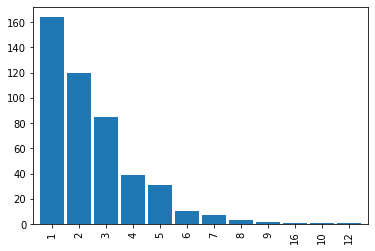

In [61]:
edges_table.groupby("Source").count()["Target"].value_counts().plot.bar(width=0.9)

Saving the nodes and edges table as csv, for import to Gephi:

## References:

DBPedia dataset (https://dbpedia.org/) released under Creative Commons Attribution-ShareAlike 3.0  

The gastrodon library: https://github.com/paulhoule/gastrodon   
gastrodon documentation and examples: https://github.com/paulhoule/gastrodon/blob/master/notebooks/remote/Querying%20DBpedia.ipynb  

The MeSH browser from the National Library of Medicine: https://meshb.nlm.nih.gov/search

The UMLS API: https://documentation.uts.nlm.nih.gov/rest/search/#searchType  
*This product uses publicly available data from the U.S. National Library of Medicine (NLM), National Institutes of Health, Department of Health and Human Services; NLM is not responsible for the product and does not endorse or recommend this or any other product.*